# Designing a forgetting attack for a known semantic space

If

1. memory behaves like our model
2. we know the nodes and weighted edges in a person's semantic space

can we find a sequence of node activations that will make them forget a set of target words?

In [11]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(1, '../')

import copy
import string
import itertools

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

import gensim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

import graphsemnet.gsn_recursive as gsn
import graphsemnet.semantics as sem

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sns.set(font_scale=1.5)

## Pull a target semantic space from the Google News pretrained word2vec space

In [3]:
google_news_w2v_path = '/Users/beau/Desktop/Projects/Language/language_repo/GoogleNews-vectors-negative300.bin'
google_news = gensim.models.KeyedVectors.load_word2vec_format(google_news_w2v_path, binary=True)

In [253]:
words = [
    'literature',
    'fiction',
    'fact',
    'deceive',
    'Trump',
    'republican',
    'democrat', 
    'liberal', 
    'conservative',
    'politician',
    'earthquake',
    'tornado',
]

In [254]:
# Build a keyed vector dictionary, omitting words that are not in the corpus
my_dsm, my_labels = sem.semantic_dsm_safe(words, google_news)
my_graph = gsn.SemanticGraph(word_dsm=my_dsm, labels=my_labels)
my_graph.set_xcal(
    dip_center=.2,
    dip_width=.2,
    min_adjust=-.025,
    max_adjust=.05
)

In [255]:
def heatmap(sem_graph, highlight=None):
    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(
        sem_graph.adj, 
        xticklabels=sem_graph.labels, 
        yticklabels=sem_graph.labels, 
        cmap='viridis',
        vmin=0,
        vmax=1
    )
    
    if highlight is not None:
        for label_x in ax.get_xticklabels():
            if label_x.get_text() in highlight:
                label_x.set_color("red")
        for label_y in ax.get_yticklabels():
            if label_y.get_text() in highlight:
                label_y.set_color("red")
    
    plt.xlabel('to')
    plt.ylabel('from')
    plt.tight_layout()

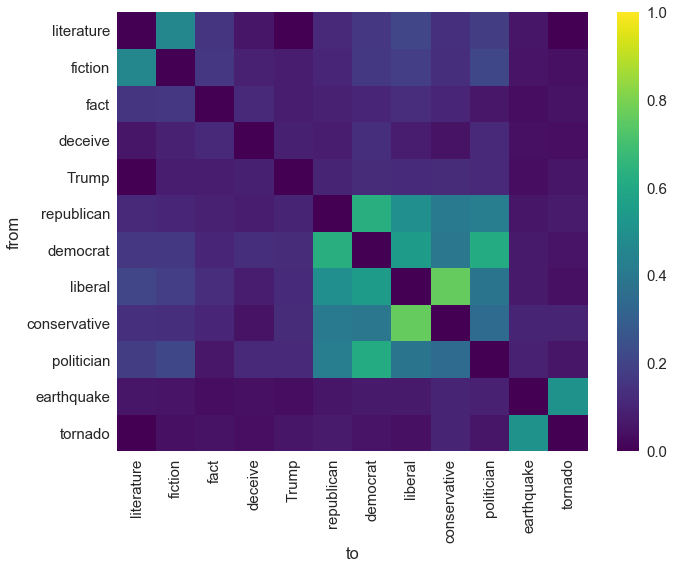

In [256]:
heatmap(my_graph)

In [257]:
def sg_to_nx(sem_graph):
    edge_bunch = []
    coords = list(itertools.combinations_with_replacement(list(range(sem_graph.adj.shape[0])), 2))
    for cx, cy in coords:
        if sem_graph.adj[cx, cy] > 0:
            edge_bunch.append((
                sem_graph.labels[cx], 
                sem_graph.labels[cy], 
                sem_graph.adj[cx, cy]
            ))
    ng = nx.DiGraph()
    ng.add_nodes_from(sem_graph.labels)
    ng.add_weighted_edges_from(edge_bunch)
    return ng

In [263]:
def nx_draw(ng, highlight=None):
    fig, ax = plt.subplots(figsize=(10,10))
    weights = [8 * ng[u][v]['weight'] for u, v in ng.edges]
    colors = [(.8, .8, 1.)] * len(ng.nodes)
    if highlight is not None:
        for label in highlight:
            colors[list(ng.nodes).index(label)] = (1., .6, .6)
    nx.draw(
        ng, 
        pos=nx.circular_layout(ng), 
        width=weights,
        with_labels=True,
        arrows=False,
        node_size=3000,
        node_color=colors
    )

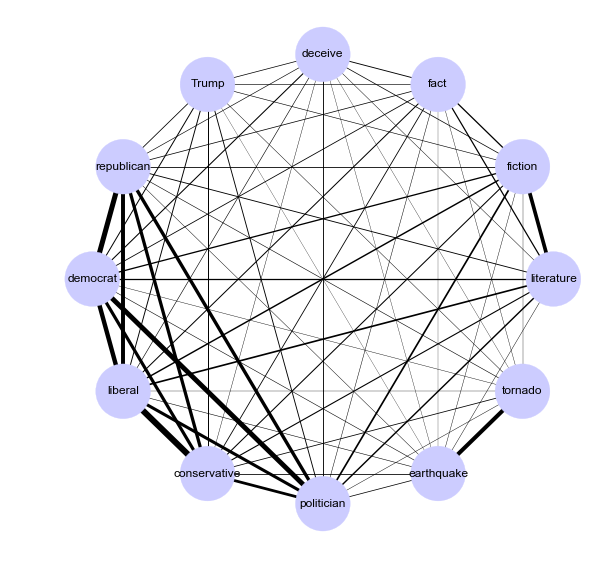

In [259]:
ng = sg_to_nx(my_graph)
nx_draw(ng)

## Find the activation that most decreases the in-degree of a word

### Monte carlo search

In [111]:
def obj(activation):
    g = copy.deepcopy(my_graph)
    current_state = np.mean(g.adj[:, 5])
    acts = g.activate_hebb(activation, decay=.7)
    g.weight_adjust_hebb(acts)
    new_state = np.mean(g.adj[:, 5])
    return current_state - new_state

In [112]:
def monte_carlo_search(graph, n):
    results = []
    for _ in range(n):
        activation = np.random.randint(0, 2, size=len(graph.labels))
        results.append((activation, obj(activation)))
    results = sorted(results, key=lambda x: -x[1])
    return results

In [113]:
results = monte_carlo_search(my_graph, 100)
results[0:10]

[(array([1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]), 0.030142128657839024),
 (array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0]), 0.028508362166786649),
 (array([1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]), 0.014854360501872832),
 (array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]), 0.0030351102526546547),
 (array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1]), -0.0018646991756319231),
 (array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]), -0.005263394153315365),
 (array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]), -0.0075461359710496945),
 (array([0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1]), -0.010258491392438507),
 (array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1]), -0.014167734142324862),
 (array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0]), -0.018667866094731922)]

In [115]:
[my_graph.labels[i] for i in np.argwhere(results[0][0]).T[0]]

['literature', 'fiction', 'Trump']

Activating these words should maximally decrease connections to the target word (modulo the effects of whatever other words you need to add to shoehorn them all into a reasonable sentence).

### Exhaustive search

In [116]:
import itertools

In [117]:
def exhaustive_search(graph):
    binary_activations = list(map(list, itertools.product([0, 1], repeat=len(graph.labels))))
    results = []
    for activation in binary_activations:
        results.append((activation, obj(np.array(activation))))
    results = sorted(results, key=lambda x: -x[1])
    return results

In [118]:
# Takes a minute
results = exhaustive_search(my_graph)
results[0:10]

[([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1], 0.041896554315938195),
 ([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1], 0.041269724223755827),
 ([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 0.040052320757600401),
 ([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1], 0.039739043018166276),
 ([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1], 0.039347103933179528),
 ([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1], 0.037936572182876771),
 ([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1], 0.037852581599229773),
 ([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1], 0.037357534970247797),
 ([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0], 0.037322486006170025),
 ([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1], 0.037121078895839099)]

In [119]:
[my_graph.labels[i] for i in np.argwhere(results[0][0]).T[0]]

['literature', 'Trump', 'tornado']

### Iteratively applying the activation that creates the most forgetting

In [260]:
max_iterations = 25
frame = 0

heatmap(my_graph)
plt.savefig("gif_temp/forgetting_heatmap_step_{0:02d}.png".format(frame))
plt.close()

ng = sg_to_nx(my_graph)
nx_draw(ng)
plt.savefig("gif_temp/forgetting_graph_step_{0:02d}.png".format(frame))
plt.close()

frame += 1

for iteration in range(max_iterations):
    print("Searching...")
    best_result = monte_carlo_search(my_graph, 500)[0]
    if best_result[1] > .01:
        words = [my_graph.labels[i] for i in np.argwhere(best_result[0]).T[0]]
        print(words)
        
        heatmap(my_graph, highlight=words)
        plt.savefig("gif_temp/forgetting_heatmap_step_{0:02d}.png".format(frame))
        plt.close()
        
        ng = sg_to_nx(my_graph)
        nx_draw(ng, highlight=words)
        plt.savefig("gif_temp/forgetting_graph_step_{0:02d}.png".format(frame))
        plt.close()
        
        frame += 1
        
        acts = my_graph.activate_hebb(best_result[0], decay=.7)
        my_graph.weight_adjust_hebb(acts)
        
        heatmap(my_graph, highlight=words)
        plt.savefig("gif_temp/forgetting_heatmap_step_{0:02d}.png".format(frame))
        plt.close()
        
        ng = sg_to_nx(my_graph)
        nx_draw(ng, highlight=words)
        plt.savefig("gif_temp/forgetting_graph_step_{0:02d}.png".format(frame))
        plt.close()
        
        frame += 1
        
    else:
        print("stabilized")
        break

Searching...
['fiction', 'Trump', 'tornado']
Searching...
['literature', 'fiction', 'fact', 'deceive', 'Trump']
Searching...
['fiction', 'Trump', 'earthquake']
Searching...
['literature', 'fiction', 'deceive', 'conservative', 'tornado']
Searching...
['deceive', 'liberal', 'tornado']
Searching...
['literature', 'fact', 'deceive', 'tornado']
Searching...
['literature', 'fact', 'conservative', 'politician', 'tornado']
Searching...
['fiction', 'politician']
Searching...
['literature', 'fiction', 'fact', 'Trump', 'liberal']
Searching...
stabilized


In [261]:
! convert -delay 50 -loop 0 gif_temp/forgetting_graph_step_??.png forgetting_graph.gif

<img src="forgetting_graph.gif" />

In [262]:
! convert -delay 50 -loop 0 gif_temp/forgetting_heatmap_step_??.png forgetting_heatmap.gif

<img src="forgetting_heatmap.gif">

In [264]:
! ffmpeg -r 2 -i gif_temp/forgetting_graph_step_%02d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p forgetting_graph.mp4
! ffmpeg -r 2 -i gif_temp/forgetting_heatmap_step_%02d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p forgetting_heatmap.mp4

ffmpeg version 3.2.2 Copyright (c) 2000-2016 the FFmpeg developers
  built with Apple LLVM version 8.0.0 (clang-800.0.42.1)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/3.2.2 --enable-shared --enable-pthreads --enable-gpl --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --disable-lzma --enable-vda
  libavutil      55. 34.100 / 55. 34.100
  libavcodec     57. 64.101 / 57. 64.101
  libavformat    57. 56.100 / 57. 56.100
  libavdevice    57.  1.100 / 57.  1.100
  libavfilter     6. 65.100 /  6. 65.100
  libavresample   3.  1.  0 /  3.  1.  0
  libswscale      4.  2.100 /  4.  2.100
  libswresample   2.  3.100 /  2.  3.100
  libpostproc    54.  1.100 / 54.  1.100
Input #0, image2, from 'gif_temp/forgetting_graph_step_%02d.png':
  Duration: 00:00:00.76, start: 0.000000, bitrate: N/A
    Stream #0:0: Video: png, rgba(pc), 720x720 [SAR 2834:2834 DAR 1:1], 25 fps

<img src='sunshine.jpg'>